In [29]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pathlib import Path
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
np.random.seed(111)   

In [30]:
auth.authenticate_user()
g_auth = GoogleAuth()
g_auth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(g_auth)
drive

In [31]:
file_id = drive.ListFile({'q':"title='train.zip'"}).GetList()[0]
f1 = drive.CreateFile({'id': file_id['id']})
f1.GetContentFile('train.zip')

file_id = drive.ListFile({'q':"title='train_cleaned.zip'"}).GetList()[0]
f2 = drive.CreateFile({'id': file_id['id']})
f2.GetContentFile('train_cleaned.zip')

file_id = drive.ListFile({'q':"title='test.zip'"}).GetList()[0]
f3 = drive.CreateFile({'id': file_id['id']})
f3.GetContentFile('test.zip')

In [32]:
!unzip train.zip
!unzip train_cleaned.zip
!unzip test.zip

Archive:  train.zip
replace train/101.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  inflating: train/128.png           
  inflating: train/129.png           
  inflating: train/131.png           
 extracting: train/132.png           
 extr

In [33]:
path_files = '/content/'

In [34]:
import os 
train_directory = os.path.join(path_files,
                         'train')
train_cleaned_directory = os.path.join(path_files,
                         'train_cleaned')
test_directory = os.path.join(path_files,
                        'test')

In [35]:
X = []
Y = []
X_test = []

for img in os.listdir(train_directory):
    img = load_img(train_directory + "/" + img, color_mode = "grayscale",target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in os.listdir(train_cleaned_directory):
    img = load_img(train_cleaned_directory + "/" + img, color_mode = "grayscale",target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)

for img in os.listdir(test_directory):
    img = load_img(test_directory + "/" + img, color_mode = "grayscale",target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X_test.append(img)
    if len(X_test) == 4:
      break


X = np.array(X)
Y = np.array(Y)
X_test = np.array(X_test)

# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)

In [36]:
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError

def build_autoenocder_cnn_check():
  
  input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format
  
  x = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(input_img)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = tf.keras.layers.Dropout(rate=0.1)(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  
  x = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(encoded)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2), loss='mse', metrics = [RootMeanSquaredError()])
  return autoencoder

In [9]:
autoencoder_cnn_check = build_autoenocder_cnn_check()
autoencoder_cnn_check.summary()
callback_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 10, verbose = 1, mode = 'auto', factor = 0.1, min_lr = 0.0001)
autoencoder_cnn_check.fit(X_train, Y_train, epochs=100, batch_size=3, validation_data=(X_valid, Y_valid), callbacks = callback_lr)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 270, 64)      18496 

1/1 [==============================] - 1s 911ms/step


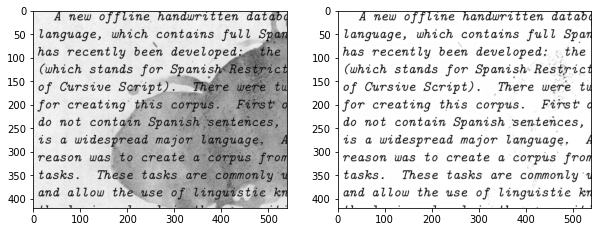

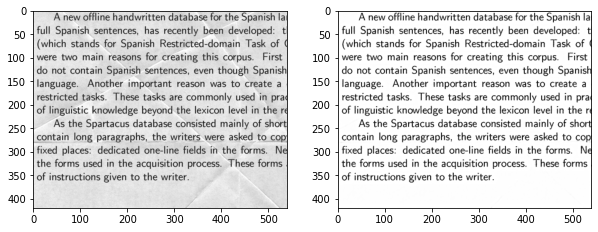

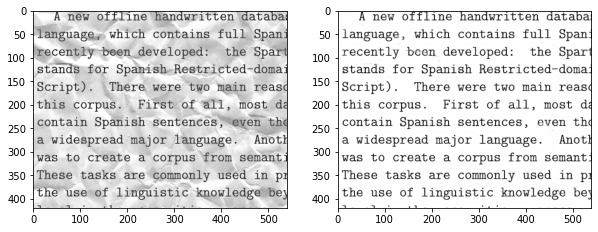

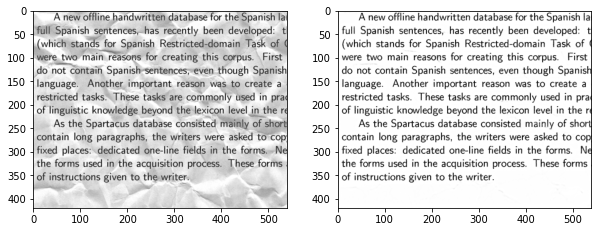

In [10]:
predicted_label_1 = np.squeeze(autoencoder_cnn_check.predict(X_test))

for i in range(4):
  f, ax = plt.subplots(1,2, figsize=(10,8))
  ax[0].imshow(np.squeeze(X_test[i]), cmap='gray')
  ax[1].imshow(predicted_label_1[i], cmap='gray')
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError

def build_autoenocder_cnn_check():
  
  input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format
  
  x = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(input_img)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = tf.keras.layers.Dropout(rate=0.1)(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  
  x = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(encoded)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mse', metrics = [RootMeanSquaredError()])
  return autoencoder

In [12]:
autoencoder_cnn_check = build_autoenocder_cnn_check()
autoencoder_cnn_check.summary()
autoencoder_cnn_check.fit(X_train, Y_train, epochs=100, batch_size=3, validation_data=(X_valid, Y_valid))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 420, 540, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 420, 540, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 210, 270, 32)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 210, 270, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 210, 270, 64)      1849

1/1 [==============================] - 0s 115ms/step


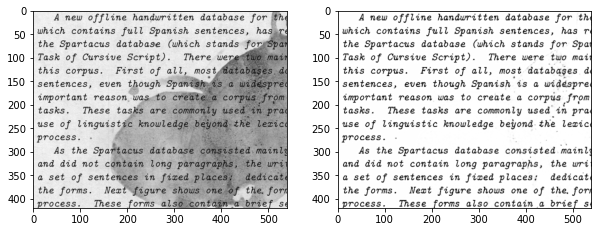

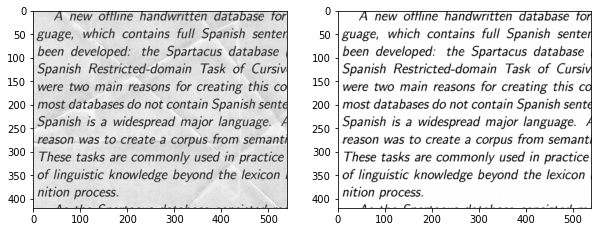

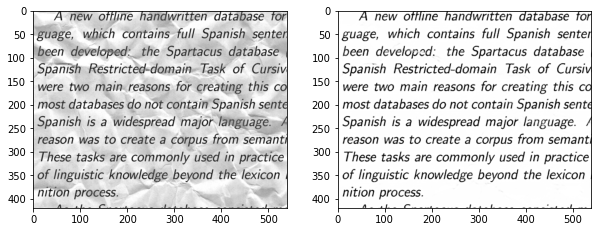

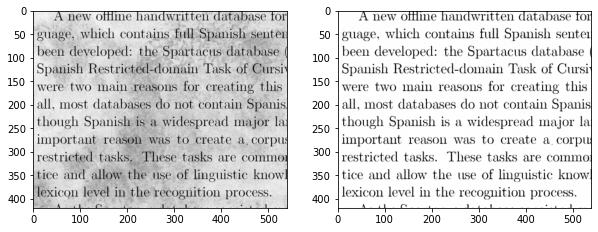

In [ ]:
predicted_label_1 = np.squeeze(autoencoder_cnn_check.predict(X_test))

for i in range(4):
  f, ax = plt.subplots(1,2, figsize=(10,8))
  ax[0].imshow(np.squeeze(X_test[i]), cmap='gray')
  ax[1].imshow(predicted_label_1[i], cmap='gray')
plt.show()


In [13]:
def build_autoenocder():
    input_img = Input(shape=(420, 540, 1), name='image_input')

    x = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding='same')(input_img)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    encoded = tf.keras.layers.BatchNormalization()(x)

    # define bottleneck layer
    bottleneck = MaxPooling2D((2, 2), padding='same')(encoded)

    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation=tf.nn.leaky_relu, strides=1, padding='same')(bottleneck)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation=tf.nn.leaky_relu, strides=2, padding='same')(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation=tf.nn.leaky_relu, strides=2, padding='same')(x)

    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse',
                        metrics=[RootMeanSquaredError()])
    return autoencoder

In [14]:
autoencoder_multi_cnn_check = build_autoenocder()
autoencoder_multi_cnn_check.summary()
autoencoder_multi_cnn_check.fit(X_train, Y_train, epochs=100, batch_size=3, validation_data=(X_valid, Y_valid))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 420, 540, 128)     1280      
                                                                 
 conv2d_11 (Conv2D)          (None, 420, 540, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 210, 270, 128)    0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 210, 270, 64)      73792     
                                                                 
 conv2d_13 (Conv2D)          (None, 210, 270, 64)      36928     
                                                           

1/1 [==============================] - 3s 3s/step


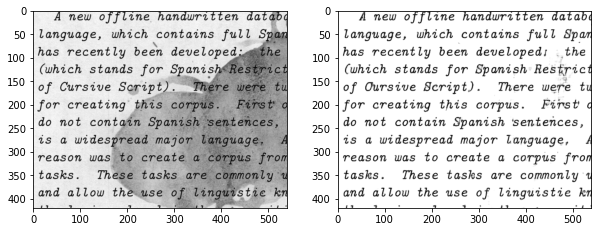

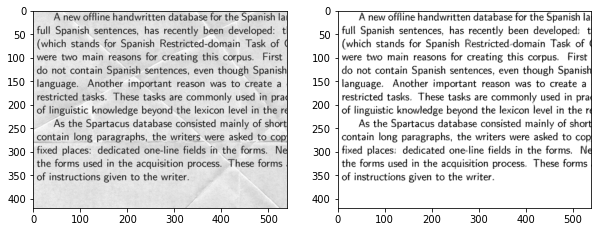

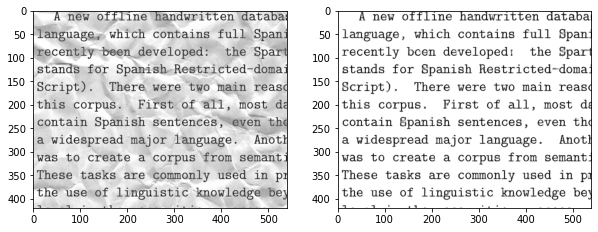

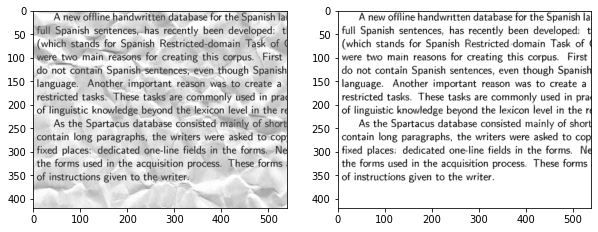

In [17]:
predicted_label_1_1 = np.squeeze(autoencoder_multi_cnn_check.predict(X_test))

for i in range(4):
  f, ax = plt.subplots(1,2, figsize=(10,8))
  ax[0].imshow(np.squeeze(X_test[i]), cmap='gray')
  ax[1].imshow(predicted_label_1_1[i], cmap='gray')
plt.show()

In [15]:
# Lets' define our autoencoder now
def build_autoenocder_cnn_2():
  
  input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  
  x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mse', metrics=[RootMeanSquaredError()])
  return autoencoder

In [16]:
autoencoder_cnn_2 = build_autoenocder_cnn_2()
autoencoder_cnn_2.summary()
autoencoder_cnn_2.fit(X_train, Y_train, epochs=100, batch_size=5, validation_data=(X_valid, Y_valid))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 420, 540, 64)      640       
                                                                 
 batch_normalization_9 (Batc  (None, 420, 540, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 210, 270, 64)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 210, 270, 128)     73856     
                                                                 
 batch_normalization_10 (Bat  (None, 210, 270, 128)    512 

1/1 [==============================] - 0s 109ms/step


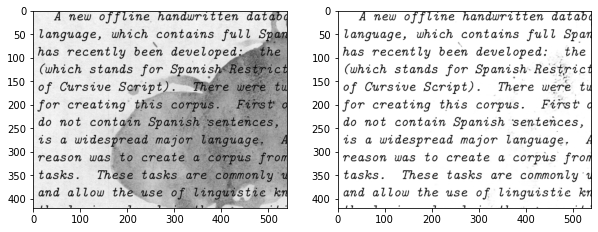

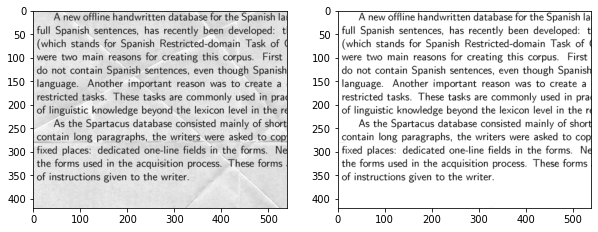

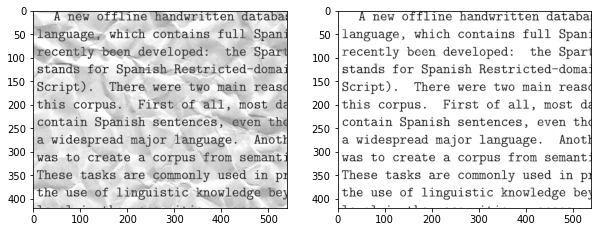

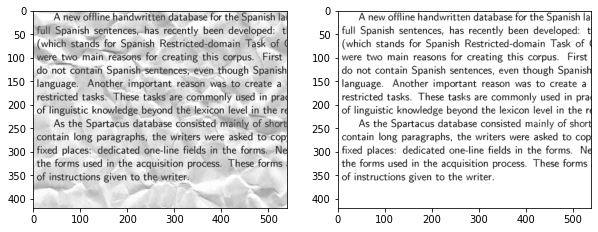

In [18]:
predicted_label_2 = np.squeeze(autoencoder_cnn_2.predict(X_test))

for i in range(4):
  f, ax = plt.subplots(1,2, figsize=(10,8))
  ax[0].imshow(np.squeeze(X_test[i]), cmap='gray')
  ax[1].imshow(predicted_label_2[i], cmap='gray')
plt.show()

In [19]:
# Lets' define our autoencoder now
def build_autoenocder_cnn_3():
  
  input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
  encoded = tf.keras.layers.Dropout(0.5)(x)
  
  x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)
  decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
  
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mse', metrics=[RootMeanSquaredError()])
  return autoencoder

In [20]:
autoencoder_cnn_3 = build_autoenocder_cnn_3()
autoencoder_cnn_3.summary()
autoencoder_cnn_3.fit(X_train, Y_train, epochs=100, batch_size=5, validation_data=(X_valid, Y_valid))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 420, 540, 64)      640       
                                                                 
 batch_normalization_13 (Bat  (None, 420, 540, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 210, 270, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 210, 270, 64)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 210, 270, 128)     7385

In [24]:
# Lets' define our autoencoder now
def build_autoenocder_cnn_5():
  
  input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format
  x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
  x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

  encoded = tf.keras.layers.Dropout(0.5)(x)
  
  
  x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(encoded)
  x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)

  decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mse', metrics=[RootMeanSquaredError()])
  return autoencoder

In [25]:
autoencoder_cnn_5 = build_autoenocder_cnn_5()
autoencoder_cnn_5.summary()
autoencoder_cnn_5.fit(X_train, Y_train, epochs=100, batch_size=3, validation_data=(X_valid, Y_valid),  shuffle=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 420, 540, 48)      480       
                                                                 
 conv2d_5 (Conv2D)           (None, 420, 540, 72)      31176     
                                                                 
 conv2d_6 (Conv2D)           (None, 420, 540, 144)     93456     
                                                                 
 batch_normalization_2 (Batc  (None, 420, 540, 144)    576       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 210, 270, 144)    0         
 2D)                                                       

1/1 [==============================] - 3s 3s/step


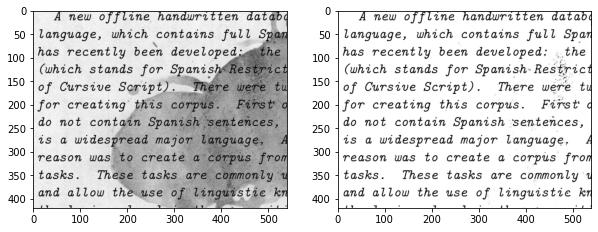

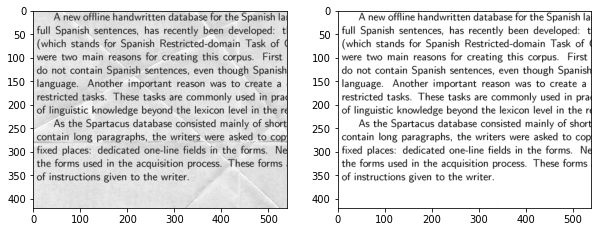

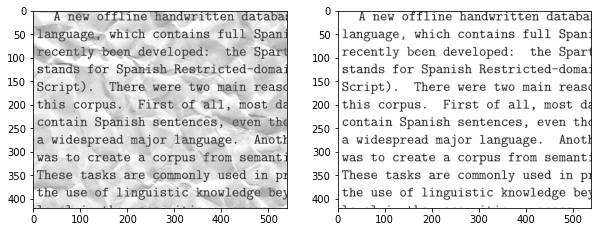

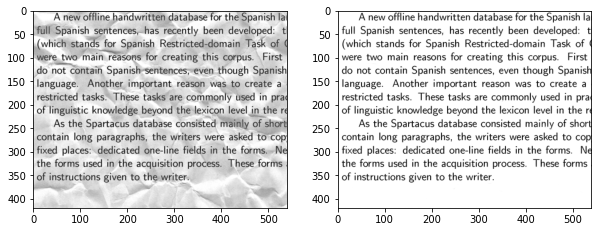

In [26]:
predicted_label_2 = np.squeeze(autoencoder_cnn_5.predict(X_test))

for i in range(4):
  f, ax = plt.subplots(1,2, figsize=(10,8))
  ax[0].imshow(np.squeeze(X_test[i]), cmap='gray')
  ax[1].imshow(predicted_label_2[i], cmap='gray')
plt.show()

In [27]:
# Lets' define our autoencoder now
def build_autoenocder_cnn_6():
  
  input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format
  x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
  x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

  encoded = tf.keras.layers.Dropout(0.3)(x)
  
  
  x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(encoded)
  x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)

  decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mse', metrics=[RootMeanSquaredError()])
  return autoencoder

In [28]:
autoencoder_cnn_6 = build_autoenocder_cnn_6()
autoencoder_cnn_6.summary()
autoencoder_cnn_6.fit(X_train, Y_train, epochs=100, batch_size=3, validation_data=(X_valid, Y_valid),  shuffle=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 420, 540, 48)      480       
                                                                 
 conv2d_12 (Conv2D)          (None, 420, 540, 72)      31176     
                                                                 
 conv2d_13 (Conv2D)          (None, 420, 540, 144)     93456     
                                                                 
 batch_normalization_4 (Batc  (None, 420, 540, 144)    576       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 210, 270, 144)    0         
 2D)                                                       

In [38]:
# Lets' define our autoencoder now
def build_autoenocder_cnn_7():
  
  input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format
  x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
  x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(288, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

  encoded = tf.keras.layers.Dropout(0.3)(x)
  
  x = tf.keras.layers.Conv2D(288, (3, 3), activation='relu', padding='same')(encoded)
  x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)

  decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mse', metrics=[RootMeanSquaredError()])
  return autoencoder

In [39]:
autoencoder_cnn_7 = build_autoenocder_cnn_7()
autoencoder_cnn_7.summary()
autoencoder_cnn_7.fit(X_train, Y_train, epochs=100, batch_size=3, validation_data=(X_valid, Y_valid),  shuffle=True)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 420, 540, 48)      480       
                                                                 
 conv2d_19 (Conv2D)          (None, 420, 540, 72)      31176     
                                                                 
 conv2d_20 (Conv2D)          (None, 420, 540, 144)     93456     
                                                                 
 conv2d_21 (Conv2D)          (None, 420, 540, 288)     373536    
                                                                 
 batch_normalization_6 (Batc  (None, 420, 540, 288)    1152      
 hNormalization)                                                 
                                                           

In [42]:
# Lets' define our autoencoder now
def build_autoenocder_cnn_8():
  
  input_img = tf.keras.layers.Input(shape=(420, 540, 1)) # adapt this if using `channels_first` image data format
  x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
  x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(288, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

  encoded = tf.keras.layers.Dropout(0.5)(x)
  
  x = tf.keras.layers.Conv2D(288, (3, 3), activation='relu', padding='same')(encoded)
  x = tf.keras.layers.Conv2D(144, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(72, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.UpSampling2D((2, 2))(x)

  decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mse', metrics=[RootMeanSquaredError()])
  return autoencoder

In [ ]:
autoencoder_cnn_8 = build_autoenocder_cnn_8()
autoencoder_cnn_8.summary()
autoencoder_cnn_8.fit(X_train, Y_train, epochs=100, batch_size=3, validation_data=(X_valid, Y_valid),  shuffle=True)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 420, 540, 48)      480       
                                                                 
 conv2d_46 (Conv2D)          (None, 420, 540, 72)      31176     
                                                                 
 conv2d_47 (Conv2D)          (None, 420, 540, 144)     93456     
                                                                 
 conv2d_48 (Conv2D)          (None, 420, 540, 288)     373536    
                                                                 
 batch_normalization_12 (Bat  (None, 420, 540, 288)    1152      
 chNormalization)                                                
                                                           